Este agarra los datos del csv con la matriz de grayscale de cada espectrograma, y se los pasa al modelo de CNN de PyTorch (definido en aux file models.py), los guarda para poder llamarlo sin re-entrenar desde otros archivos

In [6]:
import os, sys
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch.nn.functional as F

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util, models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(device))
else:
    print("CUDA not available")

Using device: cuda
NVIDIA GeForce RTX 5080


In [8]:
# UNCOMMENT THE ONE BEING USED

# NOT NOISE-REDUCED
# df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data.csv'))

# NOISE-REDUCED
df = pd.read_csv(os.path.join('..', 'database', 'meta', 'final', 'train_data2.csv'))

In [9]:
# Extract labels and pixel values
labels = df['label'].values.astype(np.int64)
features = df.drop(columns=['label']).values.astype(np.float32)
features /= 255.0
features = features.reshape(-1, 1, 313, 224)

print("features shape:", features.shape)
print("labels shape:", labels.shape)

features shape: (3070, 1, 313, 224)
labels shape: (3070,)


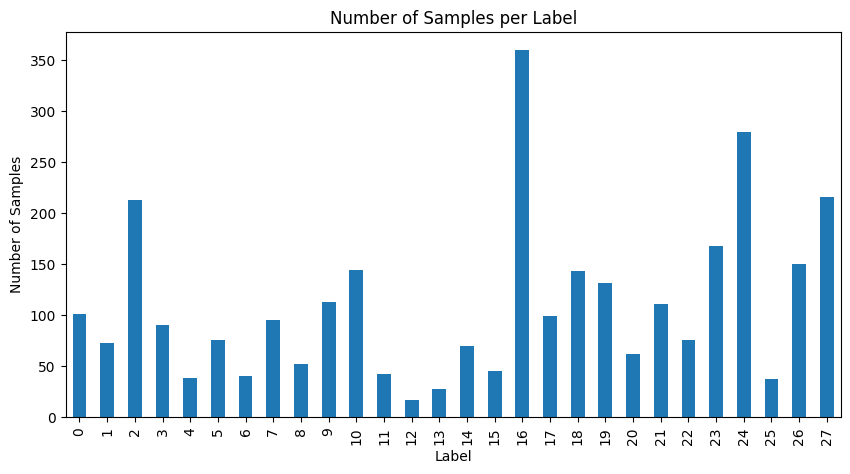

In [10]:
plt.figure(figsize=(10, 5))
df['label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Label')
plt.show()

In [18]:
import importlib
importlib.reload(models)
importlib.reload(util)

<module 'utils.util' from 'c:\\Users\\manue\\Desktop\\manum\\coding\\ChirpID-backend\\utils\\util.py'>

In [12]:
# Prepare tensors
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(X_tensor, y_tensor)

Run to Train

In [ ]:
# Run K-Fold training
results, best_results = util.k_fold_cross_validation(
    dataset=dataset,
    model_class=models.BirdCNN,
    num_classes=28,
    k_folds=5,
    num_epochs=220,
    batch_size=24,
    lr=0.001,
    aggregate_predictions=True,
    random_state=1789,
    use_class_weights=True
)

In [ ]:
# Plot accuracy and loss curves
util.plot_kfold_results(results, best_results)

In [ ]:
# Run K-Fold training
results_unb, best_runb = util.k_fold_cross_validation(
    dataset=dataset,
    model_class=models.BirdCNN,
    num_classes=28,
    k_folds=5,
    num_epochs=220,
    batch_size=24,
    lr=0.001,
    aggregate_predictions=True,
    random_state=1789,
    use_class_weights=False
)

In [ ]:
util.plot_kfold_results(results_unb, best_runb)

#### here be dragons




.

.

.

.

.




juanchi...

In [ ]:
import cProfile

cProfile.run(
    "util.k_fold_cross_validation(dataset=dataset, model_class=models.BirdCNN, num_classes=28, k_folds=5, num_epochs=250, batch_size=48, lr=0.001, aggregate_predictions=True, random_state=435, use_class_weights=True)",
    filename="profile_output.prof"
)

In [ ]:
# Print detailed F1 results
print("F1 Score Results:")
print("="*50)

if 'aggregated_f1' in results['summary']:
    print(f"Aggregated F1 Score: {results['summary']['aggregated_f1']:.4f}")
    
print(f"Mean F1 Score: {results['summary']['mean_val_f1']:.4f} ± {results['summary']['std_val_f1']:.4f}")
print(f"Individual Fold F1 Scores: {[f'{f1:.4f}' for f1 in results['summary']['individual_f1s']]}")

# Show best F1 per fold
print("\nBest F1 per fold:")
for fold_name, fold_data in results['fold_results'].items():
    print(f"{fold_name}: {fold_data['best_val_f1']:.4f}")

In [ ]:
# Select Name, Best Fold, and Model
model_name = 'bird_cnn'
best_model_state = results['fold_results']['fold_3']['model_state']
model = models.BirdCNN(num_classes=28).to(device)

# ============= Don't modify below this line ============= Ensure variables above are set correctly ============
model.load_state_dict(best_model_state)
model_dir = os.path.join('..', 'models')
os.makedirs(model_dir, exist_ok=True)
save_path = os.path.join(model_dir, f"{model_name}.pth")

util.save_model(model, model_name, model_save_path=save_path)
util.test_saved_model(save_path)

Call Single Model

In [ ]:
# Run single fold 80-20 training
single_results = util.single_fold_training(
    dataset=dataset,
    model_class=models.BirdCNN,
    num_classes=28,
    num_epochs=250,
    batch_size=48,
    lr=0.001,
    test_size=0.2,
    random_state=435,
    use_class_weights=True
)

In [ ]:
# Plot individual training curves
util.plot_single_fold_curve(single_results, metric_key='accuracies', title="Single Fold - Accuracy Curves", ylabel="Accuracy")
util.plot_single_fold_curve(single_results, metric_key='losses', title="Single Fold - Loss Curves", ylabel="Cross Entropy Loss")
util.plot_single_fold_curve(single_results, metric_key='f1s', title="Single Fold - F1 Score Curves", ylabel="Macro F1 Score")

# Print results summary
util.print_single_fold_results(single_results)

# Save the trained model
util.save_model(single_results['model'], "bird_cnn_single_fold", model_save_path=os.path.join(model_dir, "bird_cnn_single_fold.pth"))